<b><h3>Item-Based Collaborative Filtering</h3></b>

Our task will be to build a recommender for academic papers using a subsample of an academic publications structured dataset. The idea is to see if reasonably similar papers can be found in a timely and efficiet manner.

Item-based collaborative filtering provides recommendations based on similarity between items. This works in two stages: first finding the similarity scores between items, then ranking all scores to find the top-N similar item recommendations.

An item-based recommender performs three tasks:
1. Generalize information about a thing or item.
2. Score all other items to find ones 'like' this one.
3. Return ranked scores + itmes.

In [2]:
import pandas as pd

model_df = pd.read_csv('../datasets/archive_3/train.csv')

In [3]:
model_df.columns

Index(['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId',
       'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart',
       'source', 'label_confidence', 'label2_confidence', 'id'],
      dtype='object')

In [4]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8194 entries, 0 to 8193
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   string             8194 non-null   object 
 1   sectionName        7588 non-null   object 
 2   label              8194 non-null   int64  
 3   citingPaperId      8194 non-null   object 
 4   citedPaperId       8194 non-null   object 
 5   excerpt_index      8194 non-null   int64  
 6   isKeyCitation      8194 non-null   bool   
 7   label2             8194 non-null   int64  
 8   citeEnd            8194 non-null   int64  
 9   citeStart          8194 non-null   int64  
 10  source             8194 non-null   int64  
 11  label_confidence   8194 non-null   float64
 12  label2_confidence  8194 non-null   float64
 13  id                 8194 non-null   object 
dtypes: bool(1), float64(2), int64(6), object(5)
memory usage: 840.3+ KB


In [5]:
model_df.shape

(8194, 14)

In [6]:
model_df

,string,sectionName,label,citingPaperId,citedPaperId,excerpt_index,isKeyCitation,label2,citeEnd,citeStart,source,label_confidence,label2_confidence,id
0,"However, how frataxin interacts with the Fe-S ...",Introduction,1,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,11,True,3,175,168,4,1.0000,0.0,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...
1,"In the study by Hickey et al. (2012), spikes w...",Novel Quantitative Trait Loci for Seminal Root...,1,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,2,True,3,36,16,4,1.0000,0.0,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...
2,"The drug also reduces catecholamine secretion,...",Introduction,1,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,0,False,3,228,225,4,1.0000,0.0,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...
3,By clustering with lowly aggressive close kin ...,Discussion,1,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,3,False,3,110,46,4,1.0000,0.0,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...
4,Ophthalmic symptoms are rare manifestations of...,Discussion,1,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,2,False,3,239,234,4,1.0000,0.0,88b86556857f4374842d2af2e359576806239175>a5bb0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8189,"Importantly, the results of Pascalis et al. (2...",NaN,1,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,15,True,3,50,28,4,0.7350,0.0,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...
8190,"As suggested by Nguena et al, there is a need ...",DISCUSSION,1,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,1,True,3,182,179,4,0.7508,0.0,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...
8191,Skeletal muscle is also a primary site of dise...,DISCUSSION,1,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,8,False,3,120,108,4,1.0000,0.0,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...
8192,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,NaN,0,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,0,True,3,221,185,4,0.0000,0.0,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...


<b><h3>First Pass: Data Import, Cleaning, and Feature Parsing</h3></b>

Like all good science experiments, we will start off with a hypothesis. 

In this case we assume that papers that have the same sectionName and citeEnd (not sure what these columns mean, just fits my purposes thats all) will be the most useful to users. We will take a naive approach of parsing out these fields from a subsample of the overall dataset. After generating simple sparse arrays, we'll run the entire item array through an item-based collaborative filter to see if we get good results.

The item-based collaborative filter depends on a similarity score to compare items. In this case the cosine similarity provides a reasonable comparison between two non-zero vectors. Cosine similarity is the cosine of the angle between the vectors; that is, their dot product divided by their lengths. The cosine similarity always belongs to the interval [-1,1]. For example, two collinear vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of 01.

A closely related concept is the cosine distance, which is a complement of the cosine similarity in the positive space. The relation between cosine similarity and cosine distance is that similarity decreases when distance between two vectors increases and vice versa. The cosine distance is defined as:

$D_c(A,B)$  = $1\;-\;S_c(A,B)$  where $D_c$ is the cosine distance and $S_c$ is the cosine similarity.

where $S_c(A,B)$  =  $cos(\theta)$ = $\frac{A·B}{||A||||B||}$  =  $\frac{\sum_{i=1}^nA_iB_i}{\sqrt{\sum_{i=1}^nA_i^2}\sqrt{\sum_{i=1}^nB_i^2}}$

This means two collinear vectors have a cosine distance of 1-1=0; two orthogonal vectors have a cosine distance of 1-0=1; and two opposite vectors have a cosine distance of 1--1=2. 

The scipy.spatial.distance.cosine function gives the cosine distance directly so to retrieve the cosine similarity, we move thigns around in the equation:

$S_c(A,B)$  = $1\;-\;D_c(A,B)$  where $D_c$ is the cosine distance and $S_c$ is the cosine similarity.

In [7]:
model_df.isnull().sum()

string                 0
sectionName          606
label                  0
citingPaperId          0
citedPaperId           0
excerpt_index          0
isKeyCitation          0
label2                 0
citeEnd                0
citeStart              0
source                 0
label_confidence       0
label2_confidence      0
id                     0
dtype: int64

In [8]:
model_df.columns

Index(['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId',
       'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart',
       'source', 'label_confidence', 'label2_confidence', 'id'],
      dtype='object')

In [9]:
len(model_df.id.unique())

4691

In [10]:
len(model_df.sectionName.unique())

1147

In [11]:
model_df.shape

(8194, 14)

In [12]:
from scipy.spatial.distance import cosine

In [13]:
def item_collab_filter(features_df):
    item_similarities = pd.DataFrame(index=features_df.columns, columns=features_df.columns)

    for i in features_df.columns:
        for j in features_df.columns:
            item_similarities.loc[i][j] =  1 - cosine(features_df[i], features_df[j]) # similarity from distance
    return item_similarities

In [14]:
one_hot_sectionName = pd.get_dummies(model_df.sectionName, prefix=['sectionName'])

In [15]:
one_hot_citeEnd = pd.get_dummies(model_df.citeEnd, prefix=['citeEnd'])

In [16]:
one_hot_sectionName_citeEnd = one_hot_sectionName.join(one_hot_citeEnd)

In [17]:
one_hot_sectionName_citeEnd.shape

(8194, 1628)

In [18]:
from sys import getsizeof

print('Size of first feature array: ', getsizeof(one_hot_sectionName_citeEnd))

Size of first feature array:  13339976


In [19]:
one_hot_sectionName_citeEnd = one_hot_sectionName_citeEnd.T

In [20]:
first_items = item_collab_filter(one_hot_sectionName_citeEnd.loc[:,0:1000]) # first 1000

In [21]:
model_df.index

RangeIndex(start=0, stop=8194, step=1)

In [22]:
one_hot_sectionName_citeEnd.columns

RangeIndex(start=0, stop=8194, step=1)

In [23]:
first_items.index

RangeIndex(start=0, stop=1001, step=1)

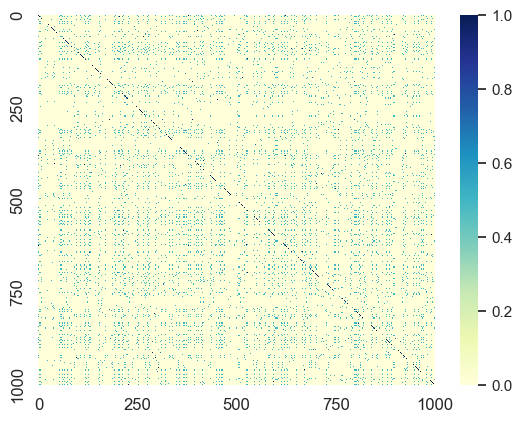

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set()

ax = sns.heatmap(first_items.fillna(0), vmin=0, vmax=1,cmap='YlGnBu', xticklabels=250, yticklabels=250)
ax.tick_params(labelsize=12)

We select the two features, convert them to one-hot encoding, join them and transpose them. This way the feature names are the indexex and the record row numbers are the column names. As such in item_collab_filter(), we first create a cosine similarity DataFrame with record row numbers as both the columns and indexes. The we loop through the vectors (columns after the transpose), and for every pair of vectors (using a nested for loop), we calculate the cosine distance using scipy.spatial.distance.consine, and subtract the distance from 1 to retrieve the cosine similarity before we insert in the square DataFrame. 

We use the cosine similarity DataFrame to create a heatmap. The diagonal line shows that the cosine similarity is correctly indicating that each paper is most similar to itself. The broken diagonal may be attributed to the NaN values in one of the columns (so we call .fillna(0)). Its not clear to me where the heatmap finds the NaN values that trip it up, because I see the same thing when I remove all NaN values from the original dataframe.

Then in the paper_recommender function, we take a record index  and the cosine distance DataFrame. We retrieve the row label (we could easily go with the column label) with that index, sort the values in descending order and store a reference to the first four rows of that Series. Then we use that row index to access the original record and those that are similar to it, and print them alongside the similarity scores.



In [25]:
def paper_recommender(paper_ix, items_df):
    print('Based on the paper: \nindex= ', paper_ix)
    print(model_df.iloc[paper_ix])
    top_results = items_df.loc[paper_ix].sort_values(ascending=False).head(4) # sort and select top 4
    print('\nTop three results: ')
    order = 1
    for i in top_results.index.tolist():
        print(order, '. Paper index= ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1
    print(top_results)

In [26]:
paper_recommender(100, first_items)

Based on the paper: 
index=  100
string               This finding is different from that in our pre...
sectionName                                                 Discussion
label                                                                2
citingPaperId                 96d59f09d602d930beddbc2785972d443efa4d93
citedPaperId                  723a4b4f3019cd5a5f8546925d8cf4478a0d03b7
excerpt_index                                                        4
isKeyCitation                                                    False
label2                                                               1
citeEnd                                                            219
citeStart                                                          203
source                                                               4
label_confidence                                                   1.0
label2_confidence                                               0.6837
id                   96d59f09d602d930beddbc2

<b><h3>Second Pass: More Engineering and a Smarter Model</h3></b>

The initial approach of creating a large, sparse array and shoving it through a filter can be improved in many ways. The next steps will focus specifically on applying better techniques to the two initial features and altering the item-based collaborative filter method for faster iteration.

First, it is time to try out some of those great feature engineering tricks for the two variables in our hypothesis. Looking deeper into the features already developed, we can choose techniques that will address each type of variable and convert it to a better feature for our recommendation system.

<b><h4>Academic Paper Recommender: Take 2</h4></b>

Let's focus on the citeEnd feature first. Using raw counts can be problematic using similarity metrics (assuming the column encodes raw counts of some sort). We can use a quantization or binning technique. The bins will be based on ranges within the variable, rather than unique number of features. To further reduce the feature space, we will dummy-code the resultant bins. Pandas can do both using built-in functions. These methods can make the results easy to interpret, so we can do a quick check of the transformed features before moving on. 

In [27]:
print("citeEnd spread:", model_df.citeEnd.min(),  "  -  ", model_df.citeEnd.max())

citeEnd spread: -1   -   3305


In [28]:
model_df.citeEnd  = model_df.citeEnd + 1  # get rid of the negative -1 minimum

In [29]:
print("citeEnd spread:", "min:",model_df.citeEnd.min(),  "max: ", model_df.citeEnd.max())

citeEnd spread: min: 0 max:  3306


In [30]:
print("Quantile spread:\n", model_df.citeEnd.quantile([0.25,0.5,0.75]))

Quantile spread:
 0.25    104.0
0.50    153.0
0.75    209.0
Name: citeEnd, dtype: float64


<Axes: xlabel='citeEnd', ylabel='Count'>

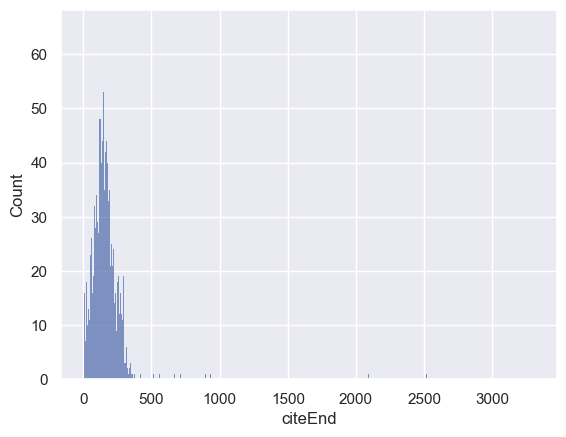

In [31]:
# plot citeEnd to see the distribution with 100
sns.histplot(data=model_df, x='citeEnd', bins= model_df.citeEnd.max() - model_df.citeEnd.min())

In [32]:
bins = int(round((model_df.citeEnd.max() - model_df.citeEnd.min())/100))

In [33]:
temp_df = pd.DataFrame(index=model_df.index)

In [34]:
temp_df

""
0
1
2
3
4
...
8189
8190
8191
8192


In [35]:
temp_df['citeEndBinned'] = pd.cut(model_df['citeEnd'].tolist(), bins, precision=0) 

In [36]:
temp_df

,citeEndBinned
0,"(100.0, 200.0]"
1,"(-3.0, 100.0]"
2,"(200.0, 301.0]"
3,"(100.0, 200.0]"
4,"(200.0, 301.0]"
...,...
8189,"(-3.0, 100.0]"
8190,"(100.0, 200.0]"
8191,"(100.0, 200.0]"
8192,"(200.0, 301.0]"


In [37]:
X_citeEnd = pd.get_dummies(temp_df['citeEndBinned'])

In [38]:
X_citeEnd.columns.codes #pd.cut yields Categorical obj

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int8)

In [39]:
X_citeEnd.columns.categories #pd.cut yields Categorical obj

IntervalIndex([(-3.0, 100.0], (100.0, 200.0], (200.0, 301.0], (301.0, 401.0], (401.0, 501.0] ... (2805.0, 2905.0], (2905.0, 3005.0], (3005.0, 3106.0], (3106.0, 3206.0], (3206.0, 3306.0]], dtype='interval[float64, right]')

Text(0, 0.5, 'Counts')

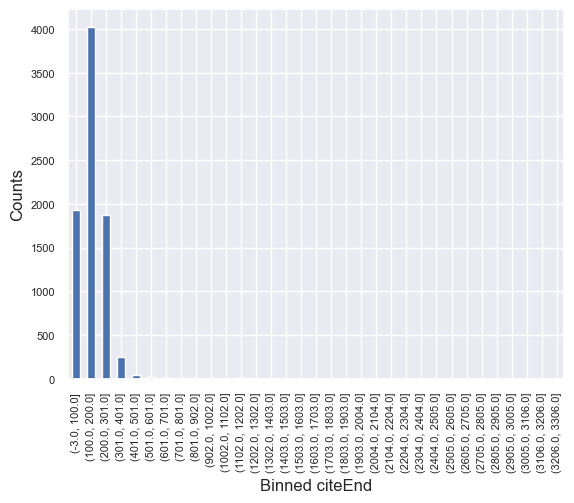

In [40]:
# plot the new distribution
fig, ax = plt.subplots()
X_citeEnd.sum().plot.bar(ax=ax)
ax.tick_params(labelsize=8)
ax.set_xlabel('Binned citeEnd', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

We have preserved the underlying distribution of the original variable through binning. If we desired a method that would benefit from a different distribution, we could alter our binning choices to change how this variable presents itself to the model. Since we are using cosine similarity, this is fine.

The sectionName feature space contributed significantly to the original model's size and processing time. We created a bag-of-phrases and since we already have a useful sparse array, we can focus on using a more efficient data type. We will convert from a Pandas DataFrame to a NumPy sparse array to improve computation time.

We will pipe our features together, and rerun our recommender to see if we have improved results, taking advantage of scikit-learn's cosine similarity function. We will also reduce the computational time by only focusing on one item at a time.

In [41]:
one_hot_sectionName_np = one_hot_sectionName.values

In [42]:
# We can see how this will make a difference in the future by looking at the size of each
print('Our pandas Series, in bytes: ', getsizeof(one_hot_sectionName))
print('Our hashed numpy array, in bytes: ', getsizeof(one_hot_sectionName_np))

Our pandas Series, in bytes:  9390468
Our hashed numpy array, in bytes:  120


In [43]:
second_features = np.append(one_hot_sectionName, X_citeEnd, axis=1)

In [44]:
print("The power of feature engineering saves us, in bytes: ", getsizeof(one_hot_sectionName_citeEnd) -
 getsizeof(second_features), )

The power of feature engineering saves us, in bytes:  3901544


In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def piped_collab_filter(features_matrix, index, top_n):
    item_similarities = 1 - cosine_similarity(features_matrix[index:index+1,:], features_matrix).flatten()
    related_indices = [i for i in item_similarities.argsort()[::-1] if i != index]
    return [(index, item_similarities[index]) for index in related_indices][0:top_n]

We use the scikit-learn cosine_similarity function which takes two matrices, and computes the cosine similarity between pairs of rows from the matrices. In the function above, we pass it a matrix, a row index, so that it slices out the specified row, and computes its cosine similarity with every other matrix. Our matrix is an ndarray and so after we receive an ndarray output, we call flatten() to collapse the output into one dimension. Then we use the .argsort()
to return a list of the indices arranged in ascending order of the values they hold and then reverse them . We return the index and the cosine similarity values of the top n similar papers.

When we go to recommend a paper we take the row label and how many top similar results to return. We first check if the provided row label is actually in the DataFrame's index object. If it is , we print details before we use the index object's .get_loc() function to get the integer index for said label. It is this row index that we use to call the cosine similarity wrapper function which will return tuples of the integer index and similarity scores of the top n similar papers. With this information, we print the similar results in order.

In [46]:
def paper_recommender(items_df, paper_ix, top_n):
    if paper_ix in model_df.index:
        print('Based on the paper: ')
        print('Paper index = ', model_df.loc[paper_ix].name)
        print('Section Name : ', model_df.loc[paper_ix]['sectionName'])
        print('Cite End: ', model_df.loc[paper_ix]['citeEnd'])
        print('Abstact: ', model_df.loc[paper_ix]['string'])
        print('Paper ID: ', model_df.loc[paper_ix]['id'])

        # define the location index for the DataFrame index requested
        array_ix = model_df.index.get_loc(paper_ix)
        top_results = piped_collab_filter(items_df, array_ix, top_n)
        print('\nTop', top_n, 'results:')

        order = 1
        for i in range(len(top_results)):
            print(order, '. Paper index = ', model_df.iloc[top_results[i][0]].name)
            print('Similarity score: ', top_results[i][1])
            print('SectionName :', model_df.iloc[top_results[i][0]]['string'])
            print('Cite End: ', model_df.iloc[top_results[i][0]]['citeEnd'])
            print('Abstact: ', model_df.iloc[top_results[i][0]]['string'])
            print('Paper ID: ', model_df.iloc[top_results[i][0]]['id'],'\n')
            if order < top_n : order += 1
        
    else:
        print('Whoops! Choose another papeer. Try something from  here: \n', model_df.index[100:200])

In [47]:
paper_recommender(second_features, 2,10)

Based on the paper: 
Paper index =  2
Section Name :  Introduction
Cite End:  229
Abstact:  The drug also reduces catecholamine secretion, thereby reducing stress and leading to a modest (10-20%) reduction in heart rate and blood pressure, which may be particularly beneficial in patients with cardiovascular disease.(7) Unlike midazolam, dexmedetomidine does not affect the ventilatory response to carbon dioxide.
Paper ID:  9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a17fb8d7a3cada601d942e22eb5da6d01adbd

Top 10 results:
1 . Paper index =  5074
Similarity score:  1.0
SectionName : The present study findings concur with previous reports in that when bone defects occur they are commonly on the tibial side (3,11,22,24).
Cite End:  138
Abstact:  The present study findings concur with previous reports in that when bone defects occur they are commonly on the tibial side (3,11,22,24).
Paper ID:  9e92fc73392d4aea262aa6bae77ab379c79b37b7>2521ee9b9ba1bf7dfd4341259b97f383827fecc9 

2 . Paper index 

In [48]:
(1 - cosine_similarity([[1,0]], [[1,0]])).flatten()

array([0.])

In [49]:
1 - cosine([1,0], [1,0])

1

<b><h3>Third Pass: More Features = More Information</h3></b>

Providing more information about each item can improve the similarity scores and result in better recommendations. The abstract, stored in the 'string' column is a good candidate for tf-idf to filter through the noise and find salient associative words. This would mean that we have applied different feature engineering techniques to different columns: tf-idf to the 'string' column, quantization or binning to the 'citeEnd' column, and bag-of-phrases (one-hot-encoding) to the 'sectionName' column.

In the TfidfVectorizer below, we set the sublinear_tf agrument to True and this replaces tf with 1 + log(tf), ensuring that low document frequencies (inverse) are not given too much weight. We also set max_df=0.5, to ignore words that occur in over half of the documents (abstract strings). We can also choose to use one-hot-encoding on citingPaperId and citedPaperId.

Continued iteration on more text variables, such as finding the noun phrases of the paper titles or stemming the keywords, could bring us even closer to a best recommendation. It should be noted here that this definition of 'best' is the 'Holy Grail' of all recommenders and search engines alike. We are searching for what a user will find most helpful, which may or may not be directly represented by data. Feature engineering allows us to abstract salient features into representations such that algorithms can expose both the explicit and implicit contained in them.

In [50]:
# need to fill in NaN for sklearn use in future
filled_df = model_df.fillna('None')

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

In [57]:
X_abstract = vectorizer.fit_transform(filled_df['string'])

In [59]:
third_features = np.append(second_features, X_abstract.toarray(), axis=1)

In [60]:
model_df.columns

Index(['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId',
       'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart',
       'source', 'label_confidence', 'label2_confidence', 'id'],
      dtype='object')

In [61]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8194 entries, 0 to 8193
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   string             8194 non-null   object 
 1   sectionName        7588 non-null   object 
 2   label              8194 non-null   int64  
 3   citingPaperId      8194 non-null   object 
 4   citedPaperId       8194 non-null   object 
 5   excerpt_index      8194 non-null   int64  
 6   isKeyCitation      8194 non-null   bool   
 7   label2             8194 non-null   int64  
 8   citeEnd            8194 non-null   int64  
 9   citeStart          8194 non-null   int64  
 10  source             8194 non-null   int64  
 11  label_confidence   8194 non-null   float64
 12  label2_confidence  8194 non-null   float64
 13  id                 8194 non-null   object 
dtypes: bool(1), float64(2), int64(6), object(5)
memory usage: 840.3+ KB


In [63]:
X_citedPaperId = pd.get_dummies(model_df.citedPaperId, drop_first=True).values

In [64]:
X_citingPaperId = pd.get_dummies(model_df.citingPaperId, drop_first=True).values

In [66]:
fourth_features = np.append(third_features, X_citedPaperId, axis=1)

In [67]:
fourth_features = np.append(fourth_features, X_citingPaperId, axis=1)

In [70]:
paper_recommender(fourth_features, 2,10)

Based on the paper: 
Paper index =  2
Section Name :  Introduction
Cite End:  229
Abstact:  The drug also reduces catecholamine secretion, thereby reducing stress and leading to a modest (10-20%) reduction in heart rate and blood pressure, which may be particularly beneficial in patients with cardiovascular disease.(7) Unlike midazolam, dexmedetomidine does not affect the ventilatory response to carbon dioxide.
Paper ID:  9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a17fb8d7a3cada601d942e22eb5da6d01adbd

Top 10 results:
1 . Paper index =  1038
Similarity score:  1.0
SectionName : Duschek and Schandry (2007) reported recently that impaired brain perfusion in hypotension especially in middle cerebral arteries (MCA) can cause cognitive deficits and even depression.
Cite End:  28
Abstact:  Duschek and Schandry (2007) reported recently that impaired brain perfusion in hypotension especially in middle cerebral arteries (MCA) can cause cognitive deficits and even depression.
Paper ID:  9220935

<b><h3>Summary</h3></b>

As you can see, building models for machine learning is easy. Building good models for useful results take time and work. We hiked through the messy processes here of examining a collection of possible variables and experimenting with different feature engineering methods to achieve better results. We define 'better' here not just in terms of good outcomes from our training and testing, but also reducing the size of the model and the time it takes us to iterate over different experiments.